# Patch Augmentation

## Imports

In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import Sequence

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import random 
import os
%matplotlib inline

np.random.seed(0)

Using TensorFlow backend.


## Set Up CIFAR-10 Experiment

Here we define some functions for creating ResNet v1 and v2, etc.

Note, code for ResNet sourced from: <https://keras.io/examples/cifar10_resnet/> 

Learning rate scheduling is used by most implementations of CIFAR, so we will also implement that first:

In [2]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 190: # was 180
        lr *= 0.5e-3
    elif epoch > 180: # was 160 
        lr *= 1e-3
    elif epoch > 140: # was 120
        lr *= 1e-2
    elif epoch > 100: # was 80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

Define a RESNET layer:

In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

Define RESNET v1:

In [4]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Some options can be defined here for code further down:

In [6]:
subtract_pixel_mean = True

# Depth of the ResNet network can be defined here.
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

Prepare data (see parameters above):

In [7]:
cifar_10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(cifar_10_labels)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

Create model (see parameters above):

In [8]:
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

save_dir = os.path.join('/tmp/', 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

#model.summary()
print(model_type)

Learning rate:  0.001
ResNet20v1


## Define Mixup and Patch-Swap Classes

In [9]:
class Mixup(Sequence):
    
    def __init__(self, batch_size, x, y, probability=1.0, alpha=0.4, in_class_mix=True, sample_from_batch=False):
        self.batch_size = batch_size
        self.probability = probability
        self.alpha = alpha
        self.x_train = x
        self.y_train = y
        self.in_class_mix = in_class_mix
        self.sample_from_batch = sample_from_batch
    
    def __len__(self):
        return int(np.ceil(len(self.x_train) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        
        batch_x = np.copy(self.x_train[idx * self.batch_size:(idx+1) * self.batch_size])
        batch_y = np.copy(self.y_train[idx * self.batch_size:(idx+1) * self.batch_size])
        
        for i in range(len(batch_x)):
            
            if random.uniform(0, 1) <= self.probability:
                
                lam = np.random.beta(self.alpha, self.alpha)
                
                # Choose a random mix up image from the entire training set. It could even be itself.
                r_i = np.random.randint(0, len(self.x_train))
                
                # IGNORE FOR NOW
                # See https://forums.fast.ai/t/mixup-data-augmentation/22764
                #if not self.in_class_mix:
                #    if sample_from_batch:
                #        r_i = np.random.randint(0, len(self.batch_x))
                #        while np.argmax(batch_y[i]) == np.argmax(batch_y[r_i]):
                #            r_i = np.random.randint(0, len(batch_x)) # Change from batch_x to x_train and vice versa
                #    else:
                #        r_i = np.random.randint(0, len(self.x_train))
                #        while np.argmax(batch_y[i]) == np.argmax(y_train[r_i]):
                #            r_i = np.random.randint(0, len(x_train))
                
                mix_x = lam * batch_x[i] + (1 - lam) * self.x_train[r_i]
                mix_y = lam * batch_y[i] + (1 - lam) * self.y_train[r_i]
                
                batch_x[i] = mix_x
                batch_y[i] = mix_y
        
        return batch_x, batch_y 

In [10]:
class PatchSwap(Sequence):
    # Perhaps make random patch area? 
    def __init__(self, batch_size, x, y, probability=1.0, image_area=1024, patch_area=0.25):
        self.batch_size = batch_size
        self.x_train = x
        self.y_train = y
        self.probability = probability
        self.image_area = image_area
        self.patch_area = patch_area
        
        # Calculate various dimensions. 
        
        self.dim = int(round(math.sqrt(self.image_area)))
        
        self.crop_area_in_pixels = self.image_area * self.patch_area
        self.crop_dim = int(round(math.sqrt(self.crop_area_in_pixels)))
        self.max_horizontal_shift = (math.sqrt(self.image_area)) - self.crop_dim
        self.max_vertical_shift = (math.sqrt(self.image_area)) - self.crop_dim
        
    def __len__(self):
        return int(np.ceil(len(self.x_train) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        
        batch_x = np.copy(self.x_train[idx * self.batch_size:(idx+1) * self.batch_size])
        batch_y = np.copy(self.y_train[idx * self.batch_size:(idx+1) * self.batch_size])
        
        for i in range(len(batch_x)):
            
            if np.random.uniform(0, 1) <= self.probability:

                r_i = np.random.randint(0, len(self.x_train))
                
                x1 = np.random.randint(0, self.dim - self.crop_dim)
                x2 = x1 + self.crop_dim
                y1 = np.random.randint(0, self.dim - self.crop_dim)
                y2 = y1 + self.crop_dim

                batch_x[i][x1:x2, y1:y2, :] = self.x_train[r_i][x1:x2, y1:y2, :]
                                
                lambda_value = self.patch_area 
                # OLD:
                # batch_y[i] = lambda_value * batch_y[i] + (1 - lambda_value) * self.y_train[r_i]
                batch_y[i] = (1- lambda_value) * batch_y[i] + lambda_value * self.y_train[r_i]
            
        return batch_x, batch_y

Create a Patch-Swap generator:

In [ ]:
patch_swap_generator = PatchSwap(batch_size=128, 
                                 x=x_train, 
                                 y = y_train, 
                                 probability=0.5, 
                                 patch_area=0.25)

Create a generator based on Mixup above:

In [ ]:
mixup_generator = Mixup(batch_size=128, 
                        x=x_train, 
                        y=y_train, 
                        probability=0.5, 
                        alpha=0.4)

Start training without generator:

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=200,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

Start training with a generator:

In [ ]:
# fit_generator(generator, steps_per_epoch=None, 
# epochs=1, verbose=1, callbacks=None, validation_data=None, 
# validation_steps=None, validation_freq=1, class_weight=None, 
# max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
history = model.fit_generator(patch_swap_generator, 
                              epochs=200, 
                              validation_data=(x_test, y_test), 
                              shuffle=True, 
                              callbacks=callbacks, 
                              verbose=1)

In [ ]:
# Set some things here
title_acc = "Patch Augmentation Accuracy"
filename = "patch-p-0-5-fix" # patch or baseline
title_loss = "Patch Augmentation Loss"

acc_peak = np.max(history.history['val_acc'])
#plt.style.use('seaborn')
plt.style.use('default')

print(history.history.keys())
plt.plot(history.history['acc'], color='tab:red')
plt.plot(history.history['val_acc'], color='tab:blue')
#plt.axhline(y=np.max(history.history['val_acc']), xmin=0, xmax=1, linestyle='--', linewidth=1.0, color='tab:grey')
# plt.yticks(list(plt.yticks()[0]) + [0.8744])
# plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 0.87, 0.9])
#plt.ylim(0.3, 0.9)
plt.title('%s (Peak %s) - %s' % (title_acc, acc_peak, model_type))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('/tmp/acc-%s-%s.pdf' % (filename, model_type))
plt.show()
# summarize history for loss
plt.plot(history.history['loss'], color='tab:red')
plt.plot(history.history['val_loss'], color='tab:blue')
plt.title('%s - %s' % (title_loss, model_type))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('/tmp/loss-%s-%s.pdf' % (filename, model_type))
plt.show()

# Tests

## Beta Dist Plot

In [ ]:
random_array = np.random.rand(400,400,3) * 255
random_image = Image.fromarray(random_array.astype('uint8')).convert('RGBA')
random_image

In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import beta

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Define the distribution parameters to be plotted
alpha_values = [0.5, 1.5, 3.0, 0.5]
beta_values = [0.5, 1.5, 3.0, 1.5]
linestyles = ['-', '--', ':', '-.']
x = np.linspace(0, 1, 1002)[1:-1]

#------------------------------------------------------------
# plot the distributions
#fig, ax = plt.subplots(figsize=(5, 3.75))

#for a, b, ls in zip(alpha_values, beta_values, linestyles):
#    dist = beta(a, b)

dist = beta(0.4, 0.4)

plt.plot(x, dist.pdf(x), ls='-',
         label=r'$\alpha=%.1f$' % (0.4))

plt.xlim(0, 1)
plt.ylim(0, 5)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\alpha)$')
plt.title('Beta Distribution')

plt.legend(loc=0)
plt.savefig("/tmp/beta.pdf")
plt.show()

## Test of Patch Augmentation Class

Load some sample data

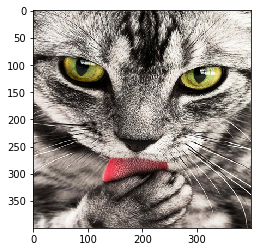

In [11]:
cat = Image.open('/home/mblo/Pictures/cat.jpg').resize((400,400), Image.LANCZOS)
dog = Image.open('/home/mblo/Pictures/dog.jpg').resize((400,400), Image.LANCZOS)
bird = Image.open('/home/mblo/Pictures/bird.jpg').resize((400,400), Image.LANCZOS)

cat = np.asarray(cat, dtype=np.uint16)
dog = np.asarray(dog, dtype=np.uint16)
bird = np.asarray(bird, dtype=np.uint16)
plt.imshow(cat)

Create a data set using the example images above.

In [12]:
num_of_examples = 3000
x_train_exp = np.empty((num_of_examples, 400, 400, 3), dtype=np.uint16)
y_train_exp = []

for i in range(0, num_of_examples):
    
    r = random.choice([0,1,2])
    
    if r == 0:
        x_train_exp[i,:,:,:] = cat
        y_train_exp.append([1.0, 0.0, 0.0]) 
    elif r == 1:
        x_train_exp[i,:,:,:] = dog
        y_train_exp.append([0.0, 1.0, 0.0])
    else: 
        x_train_exp[i,:,:,:] = bird
        y_train_exp.append([0.0, 0.0, 1.0])

y_train_exp = np.array(y_train_exp)

# Confirm some numbers

print("Image array shape: %s, length of label vector: %s" % (x_train_exp.shape, len(y_train_exp)))

cat_count, dog_count, bird_count = 0, 0, 0
for i in range(0, len(y_train_exp)):
    if np.argmax(y_train_exp[i]) == 0:
        cat_count += 1
    elif np.argmax(y_train_exp[i]) == 1:
        dog_count += 1
    else:
        bird_count += 1

print("Number of cats: %s, number of dogs: %s, number of birds: %s." % (cat_count, dog_count, bird_count))

assert (cat_count + dog_count + bird_count) == num_of_examples

Image array shape: (3000, 400, 400, 3), length of label vector: 3000
Number of cats: 1027, number of dogs: 991, number of birds: 982.


Choose a random example and confirm its image and label:

Cat  = [1. 0. 0.]
Dog  = [0. 1. 0.]
Bird = [0. 0. 1.]

Random index: 976
Label vector: [1. 0. 0.]


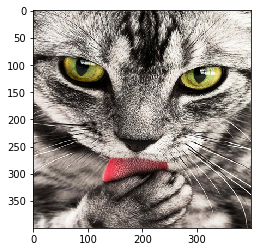

In [13]:
print("Cat  = [1. 0. 0.]\nDog  = [0. 1. 0.]\nBird = [0. 0. 1.]\n")
idx = np.random.randint(0, len(x_train_exp))
print("Random index: %s" % idx)
plt.imshow(x_train_exp[idx])
print("Label vector: %s" % y_train_exp[idx])

Make some patched images, first by creating a patch generator:

In [25]:
b_size = 128
m = PatchSwap(b_size, x=x_train_exp, y=y_train_exp, probability=0.5, image_area=400*400, patch_area=0.25)

The generator should contain approximately a samples/batch size number of samples:

In [26]:
print("Samples we generated: %s" % num_of_examples)
print("Number of batches in generator: %s" % len(m))
print("Total number of images to be outputted by generator (%s x %s): %s " % (len(m), b_size, (len(m) * b_size)))

Samples we generated: 3000
Number of batches in generator: 24
Total number of images to be outputted by generator (24 x 128): 3072 


Get the a random batch outputted by the generator:

In [27]:
r_g = np.random.randint(0, len(m))
x, y = m.__getitem__(r_g)
print("Random batch index %s" % (r_g))

Random batch index 10


Confirm the size, which should be equal to the batch size specified earlier:

In [28]:
print("Number of examples in this batch: %s" % len(x))
assert len(x) == b_size
assert len(y) == len(x)

Number of examples in this batch: 128


Look at a random image returned by the patch generator, which should contain augmented images and labels:

Cat  = [1. 0. 0.]
Dog  = [0. 1. 0.]
Bird = [0. 0. 1.]

Index: 97, Batch: 10, Label vector: [0.25 0.   0.75]


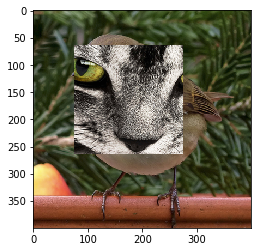

In [29]:
print("Cat  = [1. 0. 0.]\nDog  = [0. 1. 0.]\nBird = [0. 0. 1.]\n")
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Index: 23, Batch: 10, Label vector: [0.75 0.25 0.  ]


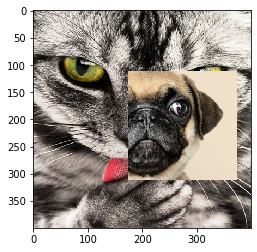

In [34]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Index: 10, Batch: 10, Label vector: [0.75 0.   0.25]


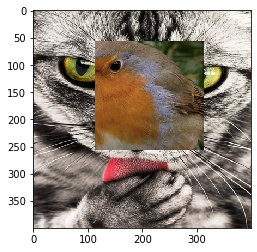

In [39]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);